# Single Cell RNA-Seq analysis with Seurat
*Waldeyr Mendes Cordeiro da Silva; compiled on Mar-2021*

## Case Study

This case study is part of the Chapter "Transcriptome Analysis Throughout RNA-seq" by Brigido et al.

Single-cell RNA-Seq (scRNA-Seq) profiles gene expression of individual cells that can be identified by Unique Molecular Identifiers (UMIs).

Fang Li et al. (2020) have conducted a study using single-cell transcriptome sequencing (scRNA-seq), single-cell BCR sequencing (scBCR-seq), and deep BCR repertoire in order to reveal neutralizing antibody sequences in patients who have recently cleared the virus.
They collected blood samples (Peripheral blood mononuclear cells - PBMCs) from 16 COVID-19 patients and 8 healthy controls to reveal the changes of immune cells caused by SARS-CoV-2 infection. 

This case study uses a single sample of the Fang Li et al. (2020) dataset to demonstrate how to identify distinct types of cells based on their transcripts.
For that we filtered the data to work only with P3 and P10 samples. 
These samples are both from female 59 years old COVID-19 patients with distinct levels of  severity.
* P3 =	59 years old, female, Severe COVID-19
* P10 =	59 years old, female, Moderate COVID-19

Data is available in https://zenodo.org/record/3744141.


Li, F., Luo, M., Zhou, W., Li, J., Jin, X., Xu, Z., ... & Jiang, Q. (2020). Single cell RNA and immune repertoire profiling of COVID-19 patients reveal novel neutralizing antibody. Protein & cell, 1-5.

In [1]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(version = "3.12")

BiocManager::install('limma')
BiocManager::install('calibrate')
BiocManager::install('dplyr')
BiocManager::install('Matrix')
BiocManager::install('Seurat') # It requires R version 4.x

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.12 (BiocManager 1.30.12), R 4.0.3 (2020-10-10)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.12 (BiocManager 1.30.12), R 4.0.3 (2020-10-10)

Installing package(s) 'limma'

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.12 (BiocManager 1.30.12), R 4.0.3 (2020-10-10)

Installing package(s) 'calibrate'

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

'getOption("repos")' replaces Bioconductor standard repositories, s

In [2]:
options(warn=-1)

library(limma)
library(calibrate)
library(dplyr)
library(Matrix)
library(Seurat)

packageVersion("limma")
packageVersion("calibrate")
packageVersion("dplyr")
packageVersion("Matrix")
packageVersion("Seurat")

Loading required package: MASS


Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject



[1] ‘3.46.0’

[1] ‘1.7.7’

[1] ‘1.0.5’

[1] ‘1.3.2’

[1] ‘4.0.1’

Download and read data from https://zenodo.org/record/3744141

In [5]:
#system("wget https://zenodo.org/record/3744141/files/COVID-19.tar.gz")
#system("tar -xzvf COVID-19.tar.gz")
covid_19_data <- Read10X(data.dir = "COVID-19")
dim(covid_19_data) # dimensions for full data

[1] 33538 96404

Filtering data to work only with P3 and P10 samples. 
* P3 =	59 years old, female, Severe COVID-19
* P10 =	59 years old, female, Moderate COVID-19

In [6]:
p3_and_p10_data <- covid_19_data[, grep(pattern = "P3|P10", colnames(covid_19_data))]
dim(p3_and_p10_data) # dimensions for selected data

[1] 33538 16056

Initialize the Seurat object with the raw (non-normalized data) constrained by the following parameters:
* minimal of two cells with at least 20 expressed genes and at least 1000 features.


In [7]:
covid_p3_p10 <- CreateSeuratObject(
    counts = p3_and_p10_data, 
    project = "COVID-19", 
    min.cells = 2, 
    min.genes = 20, 
    min.features = 2000
)
dim(covid_p3_p10)

[1] 17169  2123

Create a column to identify the patients. It is going to be useful for some plots. \[Caution: It takes some time, maybe 2 min\].

In [8]:
covid_p3_p10[["patient"]] <- sapply(strsplit(colnames(covid_p3_p10),"-"), `[`, 1)
head(covid_p3_p10[[]])

,orig.ident,nCount_RNA,nFeature_RNA,patient
,<fct>,<dbl>,<int>,<chr>
P3-AAACCTGAGTACCGGA,COVID-19,6501,2063,P3
P3-AAACGGGCATCCGGGT,COVID-19,8794,2541,P3
P3-AAAGATGGTATCAGTC,COVID-19,6605,2118,P3
P3-AAAGATGTCGCTTGTC,COVID-19,8523,2391,P3
P3-AAATGCCCACAGATTC,COVID-19,8314,2520,P3
P3-AAATGCCTCACAACGT,COVID-19,10841,3029,P3


Before to start the data processing, let’s flag some information on these data. 
The [[]] operator can add columns to a object metadata. 
In this case, we stash QC stats mitochondrial samples, which are identified starting by "MT-"

In [9]:
covid_p3_p10[["perc_mitochondrial"]] <- PercentageFeatureSet(covid_p3_p10, pattern = "^MT-")
head(covid_p3_p10[[]])

,orig.ident,nCount_RNA,nFeature_RNA,patient,perc_mitochondrial
,<fct>,<dbl>,<int>,<chr>,<dbl>
P3-AAACCTGAGTACCGGA,COVID-19,6501,2063,P3,7.891094
P3-AAACGGGCATCCGGGT,COVID-19,8794,2541,P3,5.992722
P3-AAAGATGGTATCAGTC,COVID-19,6605,2118,P3,4.799394
P3-AAAGATGTCGCTTGTC,COVID-19,8523,2391,P3,4.376393
P3-AAATGCCCACAGATTC,COVID-19,8314,2520,P3,5.436613
P3-AAATGCCTCACAACGT,COVID-19,10841,3029,P3,4.750484


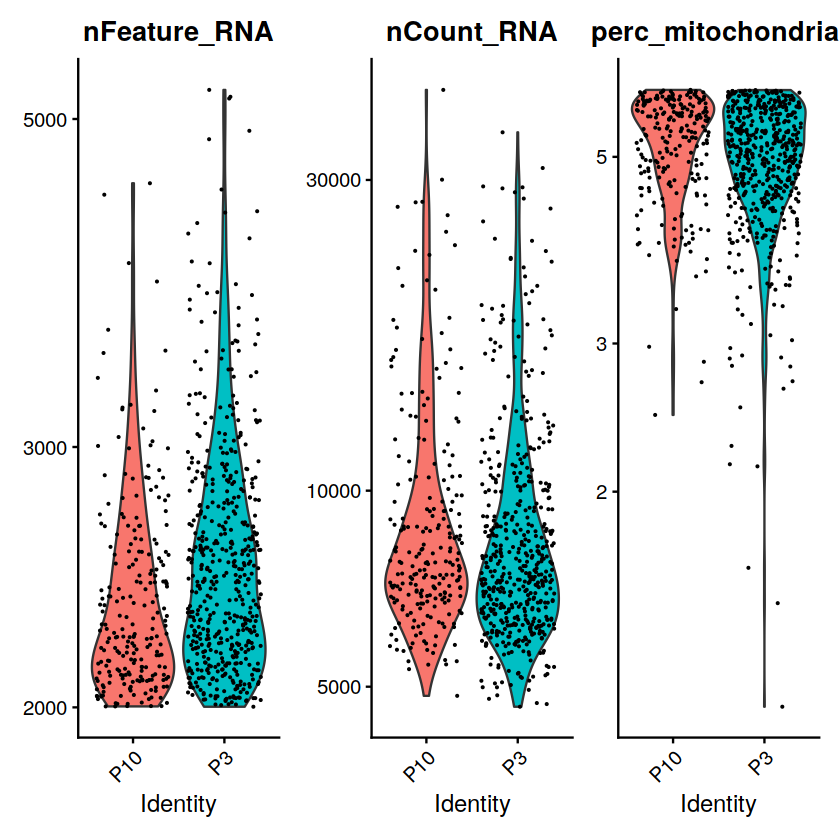

In [12]:
plot_perc_mitochondrial <- VlnPlot(
    covid_p3_p10, 
    features = c("nFeature_RNA", "nCount_RNA", "perc_mitochondrial"), 
    ncol = 3, 
    group.by = "patient",
    log = TRUE
)
plot_perc_mitochondrial

Removing unwanted cells from the dataset. In this case we have applied a filter to keep only samples keeping the number of features at least equal to 2000, but with less than 5% of mitochondrial samples.

In [10]:
covid_p3_p10 <- subset(covid_p3_p10, subset = nFeature_RNA >= 2000 & perc_mitochondrial < 5)
dim(covid_p3_p10[[]])

[1] 746   5

The function LogNormalize() normalizes the feature expression measurements for each cell by the total expression It multiplies this by a scale factor (10,000 by default), and log-transforms the result. 
Normalized values will be stored in covid_p3_p10[["RNA"]]@data.

In [11]:
covid_p3_p10 <- NormalizeData(covid_p3_p10, normalization.method = "LogNormalize", scale.factor = 10000)
dim(covid_p3_p10[[]])

[1] 746   5

We can also generate a FeatureScatter, which is typically used to visualize feature-feature relationships, but can be used for anything calculated by the object, i.e. columns in object metadata, PC scores etc. In this case, it shows read count versus percentage of mitochondrial in a) and read count versus number of features in b)


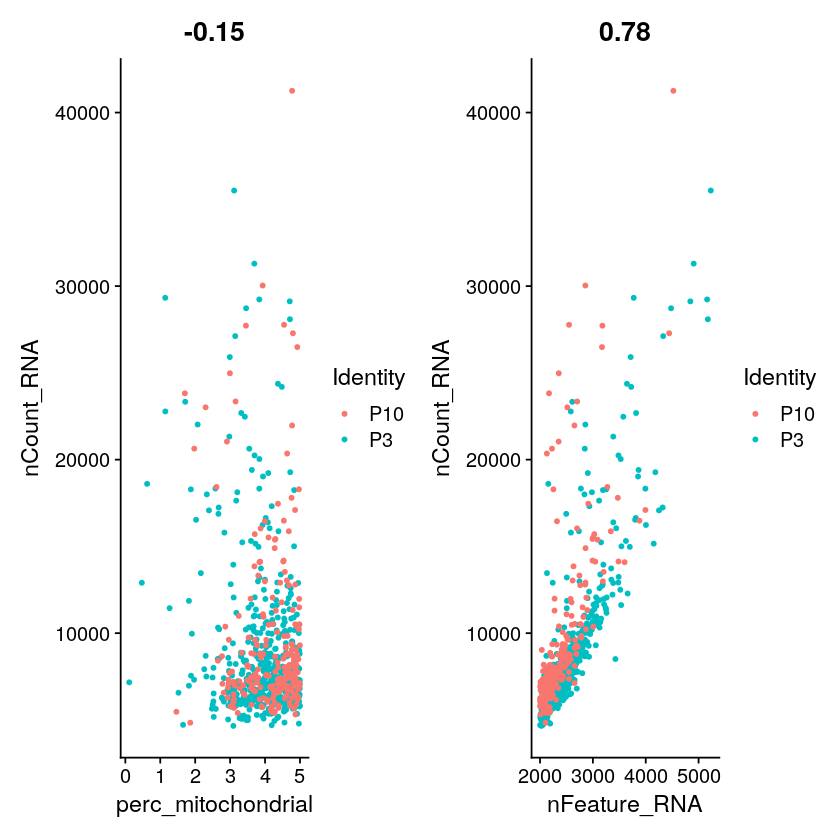

In [12]:
plot_feature_scatter_a <- FeatureScatter(
    covid_p3_p10, feature1 = "perc_mitochondrial", 
    feature2 = "nCount_RNA", 
    group.by = "patient")
plot_feature_scatter_b <- FeatureScatter(
    covid_p3_p10, 
    feature1 = "nFeature_RNA", 
    feature2 = "nCount_RNA", 
    group.by = "patient")
plot_feature_scatter_a + plot_feature_scatter_b

Once normalized, the next step is to identify highly variable features (feature selection)using the method vst which, according to the manual of Seurat, fits a line to the relationship of log (variance) and log (mean) using local polynomial regression (loess). Then, it standardizes the feature values using the observed mean and expected variance (given by the fitted line). The next step is to calculate the feature variance on the standardized values after clipping to a maximum (default is 'auto' which sets this value to the square root of the number of cells)

In [13]:
covid_p3_p10 <- FindVariableFeatures(covid_p3_p10, selection.method = "vst", nfeatures = 2000)
dim(covid_p3_p10[[]])

[1] 746   5

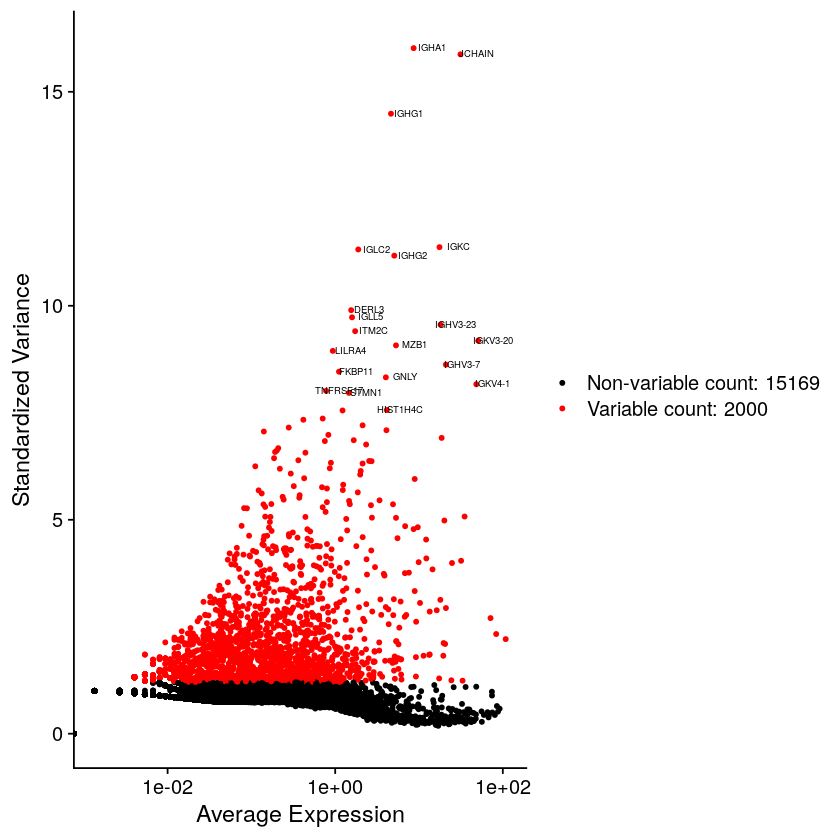

In [14]:
top20 <- head(VariableFeatures(covid_p3_p10), 20)
plot_top20 <- VariableFeaturePlot(covid_p3_p10) 
plot_top20 <- LabelPoints(plot = plot_top20, points = top20, size = 2, hjust = .75, vjust = .75) 
plot_top20

Now let’s take a look in the 20 most highly variable genes identified.

In [16]:
top20

[1] "IGHA1"    "JCHAIN"   "IGHG1"    "IGKC"     "IGLC2"    "IGHG2"   
 [7] "DERL3"    "IGLL5"    "IGHV3-23" "ITM2C"    "IGKV3-20" "MZB1"    
[13] "LILRA4"   "IGHV3-7"  "FKBP11"   "GNLY"     "IGKV4-1"  "TNFRSF17"
[19] "STMN1"    "HIST1H4C"

Before to perform the dimensional reduction, it is necessary perform a linear transformation scaling the data. It is a standard pre-processing step prior to apply techniques like PCA. 
* Scaling the data
* Linear dimensional reduction itself

In [17]:
all_genes_covid_p3_p10 <- rownames(covid_p3_p10)
covid_p3_p10 <- ScaleData(covid_p3_p10, features = all_genes_covid_p3_p10)
covid_p3_p10 <- RunPCA(covid_p3_p10, features = VariableFeatures(object = covid_p3_p10))

Centering and scaling data matrix

PC_ 1 
Positive:  PTPRCAP, CENPM, RRM2, MKI67, PTTG1, STMN1, PCLAF, C12orf75, TYMS, LIME1 
	   SEPT1, BIRC5, ZWINT, IL2RG, IL32, TRBC2, TMEM106C, HIST1H4C, MCM2, CD3D 
	   GINS2, LCK, MAD2L1, CLSPN, UBE2C, NPM1, ISG20, CD3E, SIT1, SUB1 
Negative:  CST3, S100A9, S100A8, IFITM3, S100A12, RETN, CFD, CPVL, FOS, DUSP6 
	   TMEM176B, MS4A7, CD36, CSF1R, RNASE2, PLBD1, CD163, AC020656.1, HLA-DRA, LGALS2 
	   CD300E, FCGR2A, TMEM176A, DUSP1, HLA-DRB1, CEBPD, HMOX1, APOBEC3A, GPBAR1, MAFB 
PC_ 2 
Positive:  JCHAIN, MZB1, DERL3, PPIB, ITM2C, SEC61B, HSP90B1, SSR4, IGKC, TNFRSF17 
	   SEC11C, PDIA4, SPCS1, CD74, TXNDC5, SSR3, BLNK, GNG7, SEL1L3, TMED10 
	   IGLL5, ST6GALNAC4, POU2AF1, ERLEC1, IRF4, LMAN1, TMEM258, HERPUD1, EAF2, SLAMF7 
Negative:  CAVIN2, TUBB1, GP9, AC147651.1, TSC22D1, CMTM5, TRIM58, MPIG6B, ABLIM3, TMEM40 
	   PF4, ESAM, MEIS1, TUBA8, PPBP, GATA1, GUCY1B1, AC090409.1, SELP, CLDN5 
	   LGALSL, RAB27B, MMD, DMTN, HIST1H3H, BMP6, LINC02284, SPAR

Now, let’s determine the dimensionality of the dataset. The function JackStraw() determines the statistical significance of PCA scores by randomically permuting a subset of data, and calculates projected PCA scores for these 'random' genes. Following, the ScoreJackStraw()  computes the scores significance by PCs showing a p-value distribution that is strongly skewed to the left compared to the null distribution.

In [18]:
covid_p3_p10 <- JackStraw(covid_p3_p10, num.replicate = 100)
covid_p3_p10 <- ScoreJackStraw(covid_p3_p10, dims = 1:5)

We can now cluster the cells. The function FindNeighbors() computes the k.param nearest neighbors for a given dataset using the k-nearest neighbors algorithm. Then, the function FindClusters() identifies clusters of cells from the SNN graph (result of the k-nearest neighbors algorithm). As higher is the resolution parameter as larger will be the communities. 


In [19]:
covid_p3_p10 <- FindNeighbors(covid_p3_p10, dims = 1:5)
covid_p3_p10 <- FindClusters(covid_p3_p10, resolution = 1)
head(Idents(covid_p3_p10), 5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 746
Number of edges: 19844

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8009
Number of communities: 10
Elapsed time: 0 seconds


P3-AAAGATGGTATCAGTC P3-AAAGATGTCGCTTGTC P3-AAATGCCTCACAACGT P3-AACACGTGTTTGACTG 
                  0                   1                   1                   1 
P3-AACACGTTCGTGGGAA 
                  0 
Levels: 0 1 2 3 4 5 6 7 8 9

Uniform Manifold Approximation and Projection (UMAP) is a dimensional reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. It is founded on three assumptions about the data: i) the data is uniformly distributed on a Riemannian manifold; ii) the Riemannian metric is locally constant (or can be approximated as such); iii) the manifold is locally connected.

[Caution: It takes some time.]

In [20]:
covid_p3_p10 <- RunUMAP(covid_p3_p10, dims = 1:10)
# It could be alternatively done using tSNE
#covid_p3_p10 <- RunTSNE(object = covid_p3_p10, dims.use = 1:10)

08:31:39 UMAP embedding parameters a = 0.9922 b = 1.112

08:31:39 Read 746 rows and found 10 numeric columns

08:31:39 Using Annoy for neighbor search, n_neighbors = 30

08:31:39 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

08:31:39 Writing NN index file to temp file /tmp/RtmpXFfxMD/file747777fd0875

08:31:39 Searching Annoy index using 1 thread, search_k = 3000

08:31:39 Annoy recall = 100%

08:31:39 Commencing smooth kNN distance calibration using 1 thread

08:31:40 Initializing from normalized Laplacian + noise

08:31:40 Commencing optimization for 500 epochs, with 25994 positive edges

08:31:41 Optimization finished



 Finally it is possible to plot the clusters of distinct types of cell in the blood sample. Using these parameters, we can find 10 clusters.

In [21]:
head(covid_p3_p10[[]])

,orig.ident,nCount_RNA,nFeature_RNA,patient,perc_mitochondrial,RNA_snn_res.1,seurat_clusters
,<fct>,<dbl>,<int>,<chr>,<dbl>,<fct>,<fct>
P3-AAAGATGGTATCAGTC,COVID-19,6605,2118,P3,4.799394,0,0
P3-AAAGATGTCGCTTGTC,COVID-19,8523,2391,P3,4.376393,1,1
P3-AAATGCCTCACAACGT,COVID-19,10841,3029,P3,4.750484,1,1
P3-AACACGTGTTTGACTG,COVID-19,10012,2772,P3,3.865362,1,1
P3-AACACGTTCGTGGGAA,COVID-19,7600,2258,P3,3.539474,0,0
P3-AACACGTTCTTGCCGT,COVID-19,21327,3385,P3,2.977446,6,6


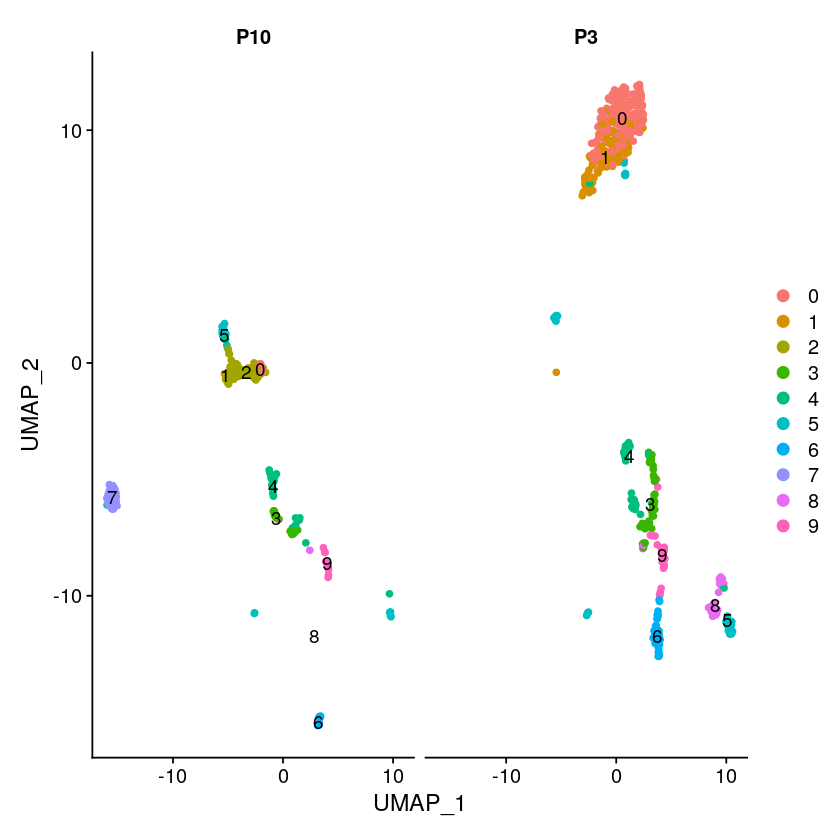

In [37]:
plot_clusters <- DimPlot(covid_p3_p10, label = TRUE, split.by="patient", pt.size=1.5)
plot_clusters

Find markers for every cluster compared to all remaining cells, report only the positive ones. \[Caution: It takes some time.\]

The function FindAllMarkers finds all differentially expressed genes for each of the identity classes in a dataset. Some constraints can be used to filter these genes, as *min.pct* that test for genes that are infrequently expressed. 

In [38]:
covid_p3_p10_markers <- FindAllMarkers(object = covid_p3_p10, min.pct = 0.05)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9



In [39]:
head(covid_p3_p10_markers)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
RETN,3.857632e-67,1.968602,0.984,0.338,6.623169e-63,0,RETN
TSPO,2.418271e-62,1.578608,0.995,0.718,4.151929e-58,0,TSPO
FCN1,3.493268e-62,1.602428,1.000,0.522,5.997593e-58,0,FCN1
CFD,9.118487e-60,1.537381,0.968,0.379,1.565553e-55,0,CFD
S100A9,4.551179e-59,1.899140,1.000,0.583,7.813919e-55,0,S100A9
S100A6,1.576473e-58,1.208379,1.000,0.962,2.706646e-54,0,S100A6


In [40]:
covid_p3_p10_markers %>% group_by(cluster)
head(covid_p3_p10_markers)

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
3.857632e-67,1.9686020,0.984,0.338,6.623169e-63,0,RETN
2.418271e-62,1.5786085,0.995,0.718,4.151929e-58,0,TSPO
3.493268e-62,1.6024283,1.000,0.522,5.997593e-58,0,FCN1
9.118487e-60,1.5373806,0.968,0.379,1.565553e-55,0,CFD
4.551179e-59,1.8991398,1.000,0.583,7.813919e-55,0,S100A9
1.576473e-58,1.2083794,1.000,0.962,2.706646e-54,0,S100A6
2.486496e-54,1.3806046,1.000,0.644,4.269066e-50,0,CST3
3.371260e-54,1.9203942,1.000,0.579,5.788117e-50,0,S100A8
4.128908e-54,1.4004567,0.932,0.318,7.088923e-50,0,TMEM176B


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
RETN,3.857632e-67,1.968602,0.984,0.338,6.623169e-63,0,RETN
TSPO,2.418271e-62,1.578608,0.995,0.718,4.151929e-58,0,TSPO
FCN1,3.493268e-62,1.602428,1.000,0.522,5.997593e-58,0,FCN1
CFD,9.118487e-60,1.537381,0.968,0.379,1.565553e-55,0,CFD
S100A9,4.551179e-59,1.899140,1.000,0.583,7.813919e-55,0,S100A9
S100A6,1.576473e-58,1.208379,1.000,0.962,2.706646e-54,0,S100A6


A volcano plot with the following configuration, Add colored points: 

* red if padj<0.05
* orange of log2FC>1
* green if both

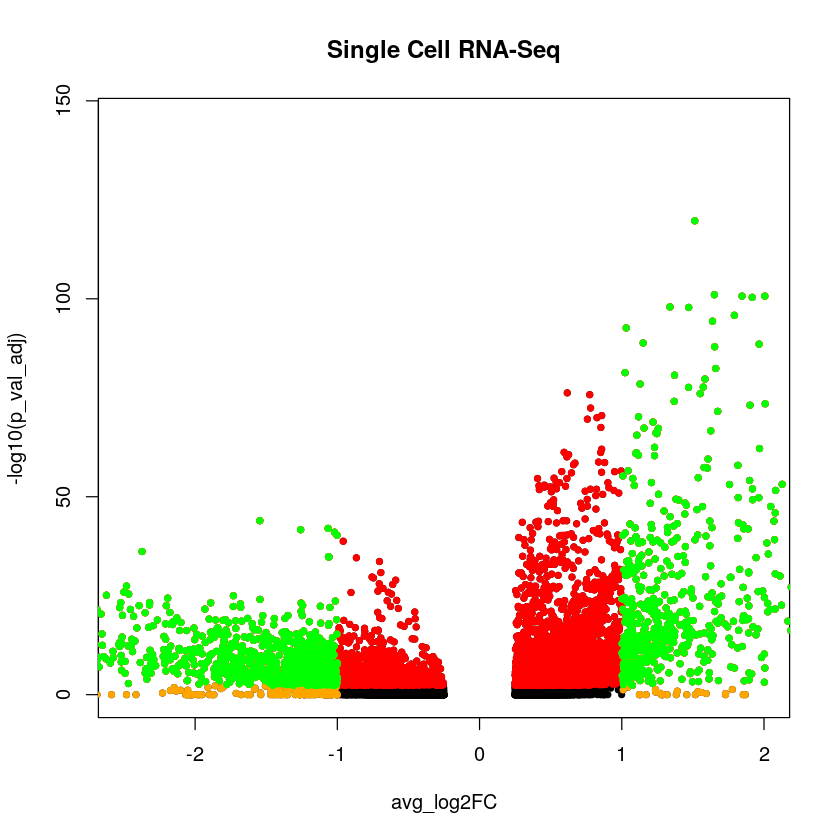

In [41]:
with(
    covid_p3_p10_markers, 
    plot(avg_log2FC, -log10(p_val_adj), 
    pch=20, 
    main="Single Cell RNA-Seq", 
    xlim=c(-2.5,2)))
with(
    subset(covid_p3_p10_markers, p_val_adj<.005 ), 
    points(avg_log2FC, -log10(p_val_adj), 
    pch=20, col="red"))
with(
    subset(covid_p3_p10_markers, abs(avg_log2FC)>1), 
    points(avg_log2FC, -log10(p_val_adj), 
    pch=20, col="orange"))
with(
    subset(covid_p3_p10_markers, p_val_adj<.005 & abs(avg_log2FC)>1), 
    points(avg_log2FC, -log10(p_val_adj), 
    pch=20, col="green"))